# Sistema de Recomendación de Películas y Series de Netflix

## Importar librerías

Importamos las librerías necesarias para el procesamiento de datos, visualización y cálculo de similitud.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [3]:
# Configuración de rutas desde config.py
import os
from config import DATA_DIR, NETFLIX_DATASET, MODELS_DIR, OUTPUT_DIR

print("📁 Verificando estructura de directorios:")
print(f"✅ Datos: {DATA_DIR}")
print(f"✅ Modelos: {MODELS_DIR}")
print(f"✅ Resultados: {OUTPUT_DIR}")
print(f"✅ Dataset principal: {NETFLIX_DATASET}")

# Verificar que el dataset principal existe
if os.path.exists(NETFLIX_DATASET):
    print(f"✅ Dataset encontrado: {NETFLIX_DATASET}")
else:
    print(f"❌ Dataset no encontrado: {NETFLIX_DATASET}")

📁 Verificando estructura de directorios:
✅ Datos: data/
✅ Modelos: models/
✅ Resultados: outputs/
✅ Dataset principal: data/netflix_dataset.csv
✅ Dataset encontrado: data/netflix_dataset.csv


## Cargar el dataset

Leemos el archivo CSV que contiene el catálogo de Netflix.

In [4]:
netflix_dataset = pd.read_csv('data/netflix_dataset.csv')
netflix_dataset.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Vista de los datos

In [5]:
netflix_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7281 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


## Información del dataset

In [10]:
dict = {}
for i in list(netflix_dataset.columns):
    dict[i] = netflix_dataset[i].value_counts().shape[0]
    
print(pd.DataFrame(dict, index=["unique count"]).transpose())

              unique count
show_id               7787
type                     2
title                 7787
director              4049
cast                  6831
country                681
date_added            1565
release_year            73
rating                  14
duration               216
listed_in              492
description           7769



## Verificación de valores nulos

Identificamos cuántos valores faltantes hay en cada columna.


In [11]:
print('Table of missing values: ')
print(netflix_dataset.isnull().sum())

Table of missing values: 
show_id            0
type               0
title              0
director        2389
cast             718
country          506
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64


## Análisis de películas vs programas de televisión

/var/folders/8d/cl39xy8929j59619h922mglr0000gq/T/ipykernel_17149/3982881101.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="type", data=netflix_dataset, palette=['#E50914', '#564D4D'])


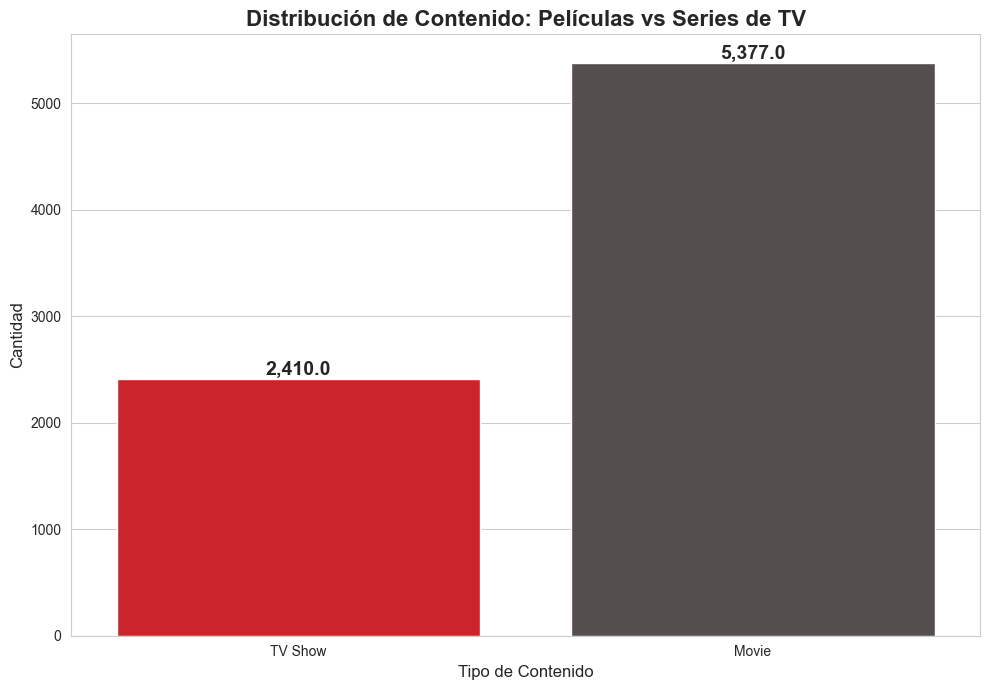

In [6]:
plt.figure(figsize=(10, 7))
sns.set_style('whitegrid')
ax = sns.countplot(x="type", data=netflix_dataset, palette=['#E50914', '#564D4D'])
ax.set_title("Distribución de Contenido: Películas vs Series de TV", fontsize=16, fontweight='bold')
ax.set_xlabel("Tipo de Contenido", fontsize=12)
ax.set_ylabel("Cantidad", fontsize=12)

# Agregar los totales encima de las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,}', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Análisis temporal de adición de contenido

Mapa de calor que muestra los patrones de adición de contenido por mes y año.

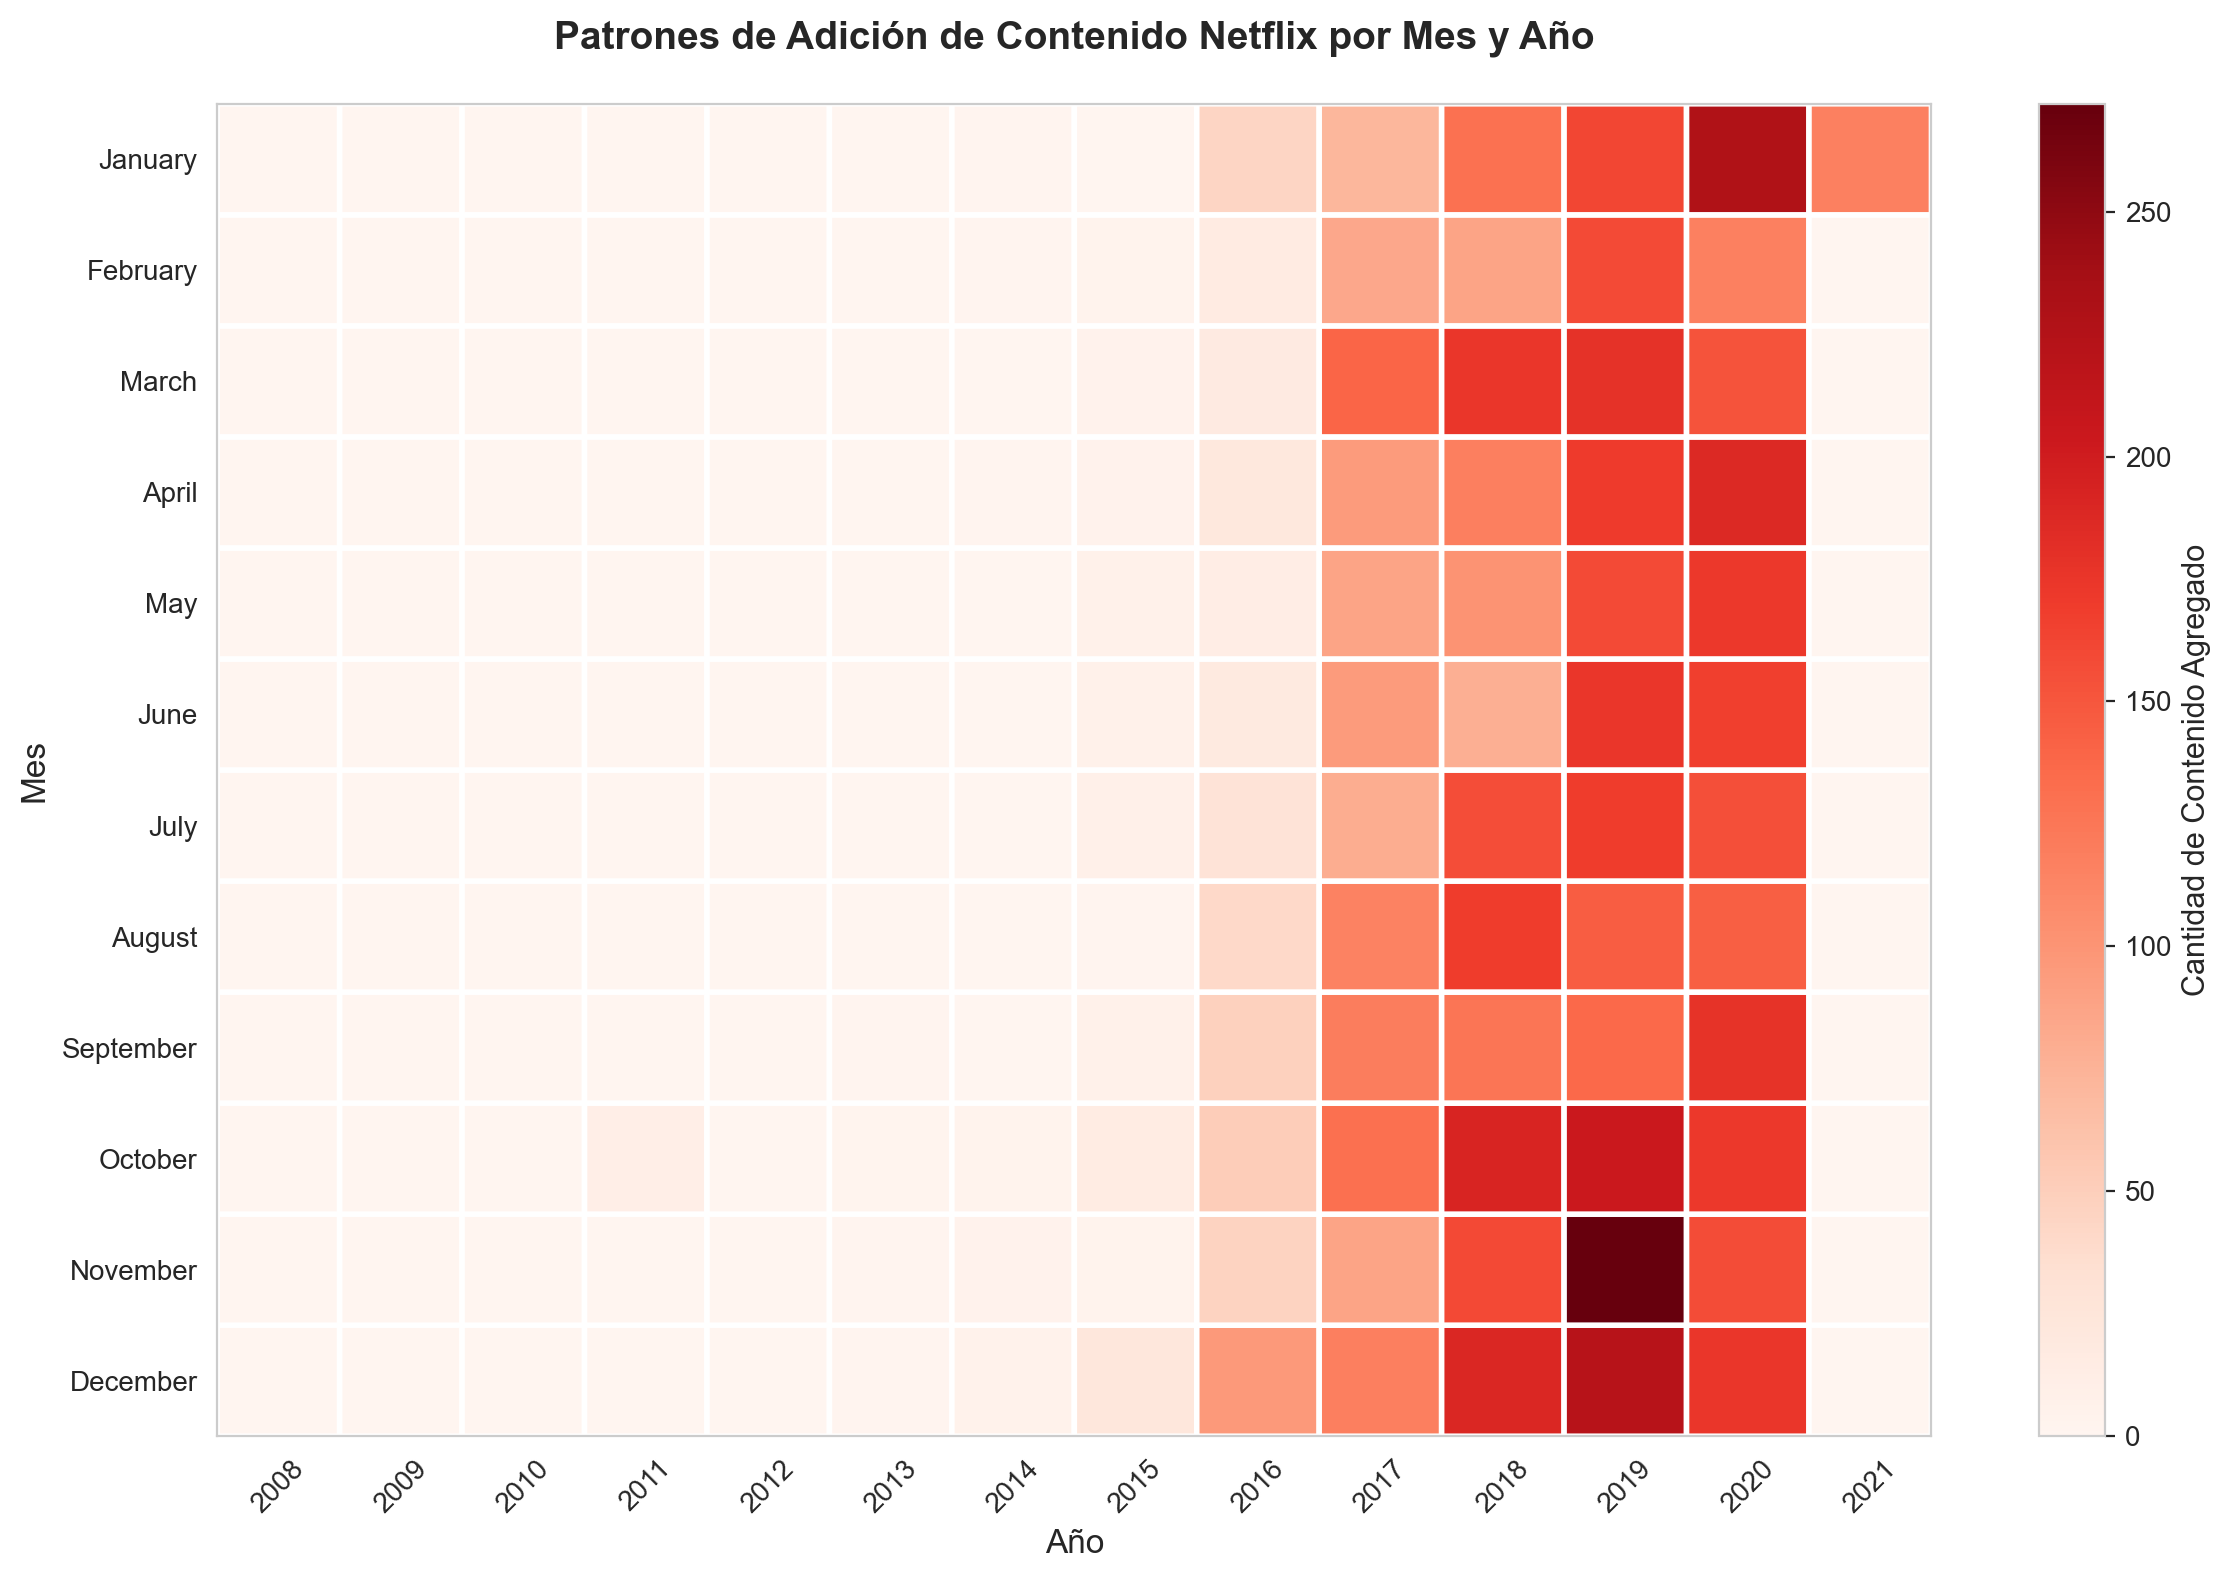

In [13]:
netflix_date = netflix_dataset[['date_added']].dropna()
netflix_date['year'] = netflix_date['date_added'].apply(lambda x: x.split(', ')[-1])
netflix_date['month'] = netflix_date['date_added'].apply(lambda x: x.lstrip().split(' ')[0])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December'][::-1]

df = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

plt.figure(figsize=(12, 8), dpi=200)
plt.pcolor(df, cmap='Reds', edgecolors='white', linewidths=2)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontsize=10, rotation=45)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontsize=10)

plt.title('Patrones de Adición de Contenido Netflix por Mes y Año', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Mes', fontsize=12)

cbar = plt.colorbar()
cbar.set_label('Cantidad de Contenido Agregado', fontsize=11)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

## Análisis de calificaciones de películas

/var/folders/8d/cl39xy8929j59619h922mglr0000gq/T/ipykernel_17149/3836438313.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


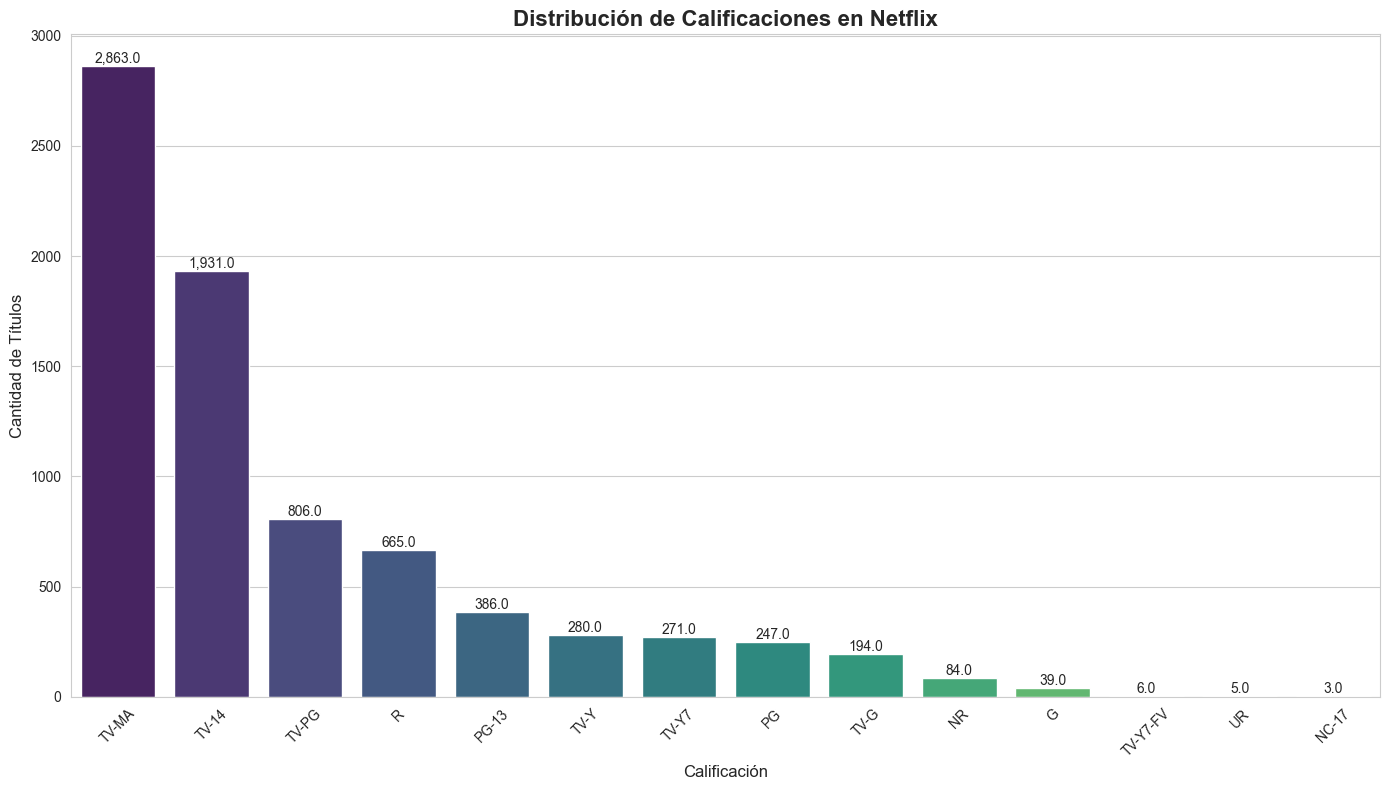

In [7]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.countplot(
    x="rating",
    data=netflix_dataset,
    palette="viridis",
    order=netflix_dataset['rating'].value_counts().index[0:15]
)
ax.set_title("Distribución de Calificaciones en Netflix", fontsize=16, fontweight='bold')
ax.set_xlabel("Calificación", fontsize=12)
ax.set_ylabel("Cantidad de Títulos", fontsize=12)
plt.xticks(rotation=45)

# Agregar valores en las barras
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,}', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Análisis de calificaciones IMDB (Opcional)

*Nota: Esta sección requiere archivos adicionales de IMDb. Si no los tienes, puedes omitir estas celdas.*

In [8]:
# Sección opcional - requiere archivos IMDb
try:
    imdb_ratings = pd.read_csv('data/imdb-ratings.csv', usecols=['weighted_average_vote'])
    imdb_titles = pd.read_csv('data/imdb-movies.csv', usecols=['title', 'year', 'genre'])
    
    ratings = pd.DataFrame({
        'Title': imdb_titles.title,
        'Release Year': imdb_titles.year,
        'Rating': imdb_ratings.weighted_average_vote,
        'Genre': imdb_titles.genre
    })
    ratings.drop_duplicates(subset=['Title', 'Release Year', 'Rating'], inplace=True)
    print(f"Datos IMDb cargados: {ratings.shape}")
    
except FileNotFoundError:
    print("Archivos IMDb no encontrados en data/. Continuando sin análisis de calificaciones externas.")
    ratings = None

Datos IMDb cargados: (85852, 4)


/var/folders/8d/cl39xy8929j59619h922mglr0000gq/T/ipykernel_17149/1710899746.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles = pd.read_csv('data/imdb-movies.csv', usecols=['title', 'year', 'genre'])


## Unir ambos conjuntos de datos (calificaciones e información de Netflix) para filtrar solo los títulos que tienen calificación en IMDB

In [9]:
# Cargar datos de IMDb (opcional)
try:
    imdb_ratings = pd.read_csv('data/imdb-ratings.csv', usecols=['weighted_average_vote'])
    imdb_titles = pd.read_csv('data/imdb-movies.csv', usecols=['title', 'year', 'genre'])
    
    ratings = pd.DataFrame({
        'Title': imdb_titles.title,
        'Release Year': imdb_titles.year,
        'Rating': imdb_ratings.weighted_average_vote,
        'Genre': imdb_titles.genre
    })
    ratings.drop_duplicates(subset=['Title', 'Release Year', 'Rating'], inplace=True)
    print(f"✅ Datos IMDb cargados: {ratings.shape}")
    
    # Crear datos combinados
    ratings_clean = ratings.dropna()
    joint_data = ratings_clean.merge(netflix_dataset, left_on='Title', right_on='title', how='inner')
    joint_data = joint_data.sort_values(by='Rating', ascending=False)
    print(f"✅ Datos combinados exitosamente: {joint_data.shape}")
    
except FileNotFoundError:
    print("ℹ️ Archivos IMDb no encontrados en data/. Continuando sin análisis de calificaciones externas.")
    ratings = None
    joint_data = None

✅ Datos IMDb cargados: (85852, 4)
✅ Datos combinados exitosamente: (2741, 16)


/var/folders/8d/cl39xy8929j59619h922mglr0000gq/T/ipykernel_17149/1348584491.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles = pd.read_csv('data/imdb-movies.csv', usecols=['title', 'year', 'genre'])


## Las 10 películas mejor valoradas en Netflix

In [ ]:
# Análisis de calidad de contenido por país
if joint_data is not None:
    print("📊 Análisis de calidad de contenido por país (con datos IMDb):")
    
    # Obtener top 10 películas mejor valoradas
    top_rated = joint_data.nlargest(10, 'Rating')[['title', 'country', 'Rating']]
    top_rated['country'] = top_rated['country'].fillna('Unknown')
    
    # Crear gráfico de barras horizontal
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_rated)))
    
    bars = plt.barh(top_rated['title'], top_rated['Rating'], color=colors)
    plt.xlabel('Rating IMDb', fontsize=12)
    plt.ylabel('Películas', fontsize=12)
    plt.title('Top 10 Películas Mejor Valoradas en Netflix (según IMDb)', 
              fontsize=14, fontweight='bold')
    
    # Agregar valores en las barras
    for i, (bar, rating) in enumerate(zip(bars, top_rated['Rating'])):
        plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{rating:.1f}', va='center', fontweight='bold')
    
    plt.xlim(0, 10)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla de información
    print("\n? Detalles de las mejores películas:")
    for idx, row in top_rated.iterrows():
        print(f"• {row['title']} ({row['country']}) - Rating: {row['Rating']:.1f}")
        
else:
    print("⚠️ Análisis de calidad no disponible - se requieren datos de IMDb")

## Principales países que crean contenidos

In [10]:
# Análisis de países productores (solo si tenemos datos IMDb)
if joint_data is not None and len(joint_data) > 0:
    country_count = joint_data['country'].value_counts().sort_values(ascending=False)
    country_count = pd.DataFrame(country_count)
    topcountries = country_count.head(11)
    
    print("Top países productores de contenido mejor valorado:")
    print(topcountries)
else:
    print("📊 Análisis de países basado en el dataset principal de Netflix:")
    
    # Análisis alternativo usando solo datos de Netflix
    netflix_countries = netflix_dataset['country'].dropna()
    
    # Procesar países múltiples (separados por comas)
    all_countries = []
    for countries_str in netflix_countries:
        countries_list = [country.strip() for country in str(countries_str).split(',')]
        all_countries.extend(countries_list)
    
    # Crear DataFrame con conteo de países
    country_series = pd.Series(all_countries)
    country_count = country_series.value_counts().head(10)
    
    print("Top 10 países productores en Netflix:")
    for i, (country, count) in enumerate(country_count.items(), 1):
        print(f"{i}. {country}: {count} títulos")

Top países productores de contenido mejor valorado:
                               count
country                             
United States                    799
India                            702
United Kingdom                   107
Canada                            56
Philippines                       50
Spain                             40
South Korea                       36
Indonesia                         35
France                            33
United Kingdom, United States     31
Australia                         30


/var/folders/8d/cl39xy8929j59619h922mglr0000gq/T/ipykernel_17149/1764333214.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_countries_netflix.values, y=top_countries_netflix.index,


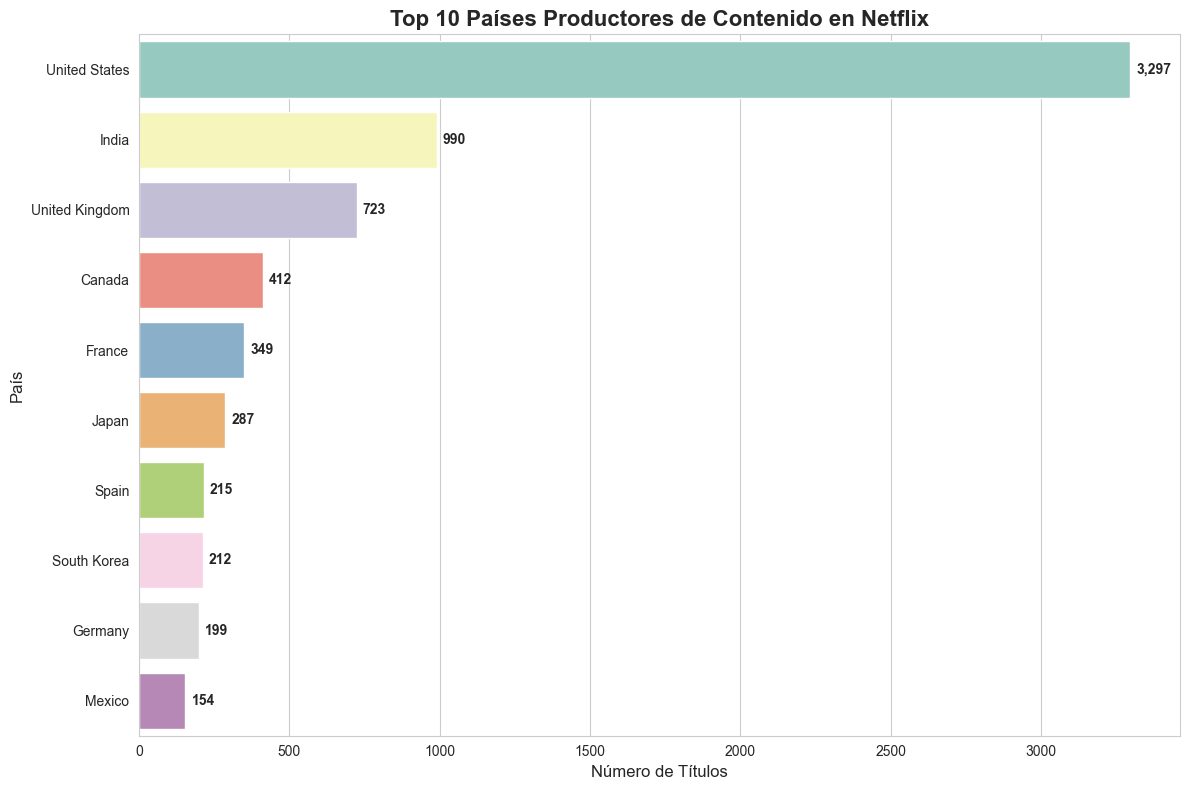

In [11]:
# Visualización de países productores usando datos de Netflix
plt.figure(figsize=(12, 8))

# Análisis de países usando todos los datos de Netflix
netflix_countries = netflix_dataset['country'].dropna()
all_countries = []

for countries_str in netflix_countries:
    countries_list = [country.strip() for country in str(countries_str).split(',')]
    all_countries.extend(countries_list)

country_series = pd.Series(all_countries)
top_countries_netflix = country_series.value_counts().head(10)

# Crear gráfico de barras
ax = sns.barplot(x=top_countries_netflix.values, y=top_countries_netflix.index, 
                palette="Set3", orient='h')
ax.set_title("Top 10 Países Productores de Contenido en Netflix", 
            fontsize=16, fontweight='bold')
ax.set_xlabel("Número de Títulos", fontsize=12)
ax.set_ylabel("País", fontsize=12)

# Agregar valores en las barras
for i, v in enumerate(top_countries_netflix.values):
    ax.text(v + 20, i, f'{v:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Análisis anual

In [12]:
Last_fifteen_years = netflix_dataset[netflix_dataset['release_year']>2005 ]
Last_fifteen_years.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


# cantidad de títulos agregados a Netflix por año de estreno

/var/folders/8d/cl39xy8929j59619h922mglr0000gq/T/ipykernel_17149/3520125935.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


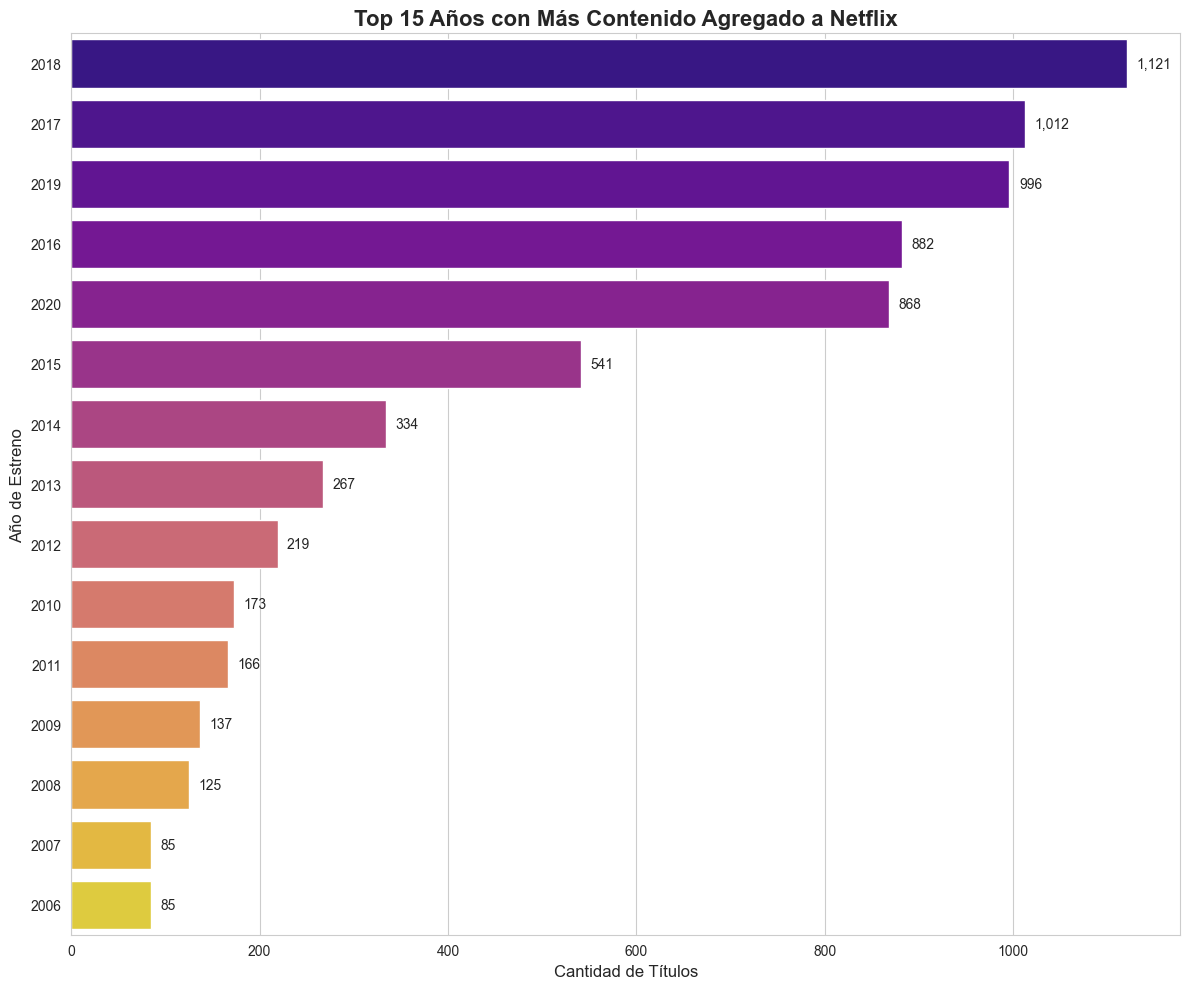

In [13]:
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")
ax = sns.countplot(
    y="release_year",
    data=Last_fifteen_years,
    palette="plasma",
    order=netflix_dataset['release_year'].value_counts().index[0:15]
)
ax.set_title("Top 15 Años con Más Contenido Agregado a Netflix", fontsize=16, fontweight='bold')
ax.set_xlabel("Cantidad de Títulos", fontsize=12)
ax.set_ylabel("Año de Estreno", fontsize=12)

# Agregar valores en las barras
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:,.0f}', 
                (width + 10, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Análisis de programas de televisión en Netflix

In [14]:
# Llenar valores nulos con 'Unknown'
netflix_shows = netflix_dataset[netflix_dataset['type'] == 'TV Show'].copy()

netflix_shows['country'] = netflix_shows['country'].fillna('Unknown')

# Crear el diccionario de conteo
countries = {}

# Obtener la lista de valores
country_list = list(netflix_shows['country'])

# Recorrer cada entrada
for entry in country_list:
    # Dividir por comas y quitar espacios
    split_countries = [c.strip() for c in entry.split(',')]
    
    # Contar cada país
    for country in split_countries:
        if country in countries:
            countries[country] += 1
        else:
            countries[country] = 1

# Revisar resultado
countries


{'Brazil': 29,
 'Turkey': 28,
 'Poland': 8,
 'United States': 866,
 'Mexico': 53,
 'Unknown': 276,
 'Japan': 184,
 'South Korea': 157,
 'United Kingdom': 256,
 'India': 75,
 'Canada': 126,
 'Italy': 23,
 'Spain': 57,
 'Australia': 60,
 'Taiwan': 70,
 'China': 45,
 'Germany': 42,
 'France': 84,
 'Singapore': 22,
 'Russia': 17,
 'Mauritius': 1,
 'South Africa': 10,
 'Lebanon': 7,
 'Colombia': 28,
 'Argentina': 18,
 'Philippines': 1,
 'Finland': 4,
 'Netherlands': 8,
 'Chile': 5,
 'Thailand': 22,
 'Nigeria': 8,
 'Saudi Arabia': 4,
 'Syria': 1,
 'Egypt': 13,
 'Kuwait': 3,
 'Belgium': 11,
 'Norway': 9,
 'Sweden': 10,
 'Denmark': 13,
 'Israel': 8,
 'Ireland': 12,
 'Iceland': 2,
 'Indonesia': 3,
 'Malaysia': 8,
 'New Zealand': 8,
 'Czech Republic': 6,
 'Cuba': 1,
 'Austria': 1,
 'Greece': 2,
 'Hong Kong': 5,
 'Pakistan': 4,
 'Luxembourg': 1,
 'Jordan': 1,
 'Uruguay': 1,
 'Azerbaijan': 1,
 'West Germany': 2,
 'Puerto Rico': 1,
 'Malta': 1,
 'Senegal': 1,
 'Ukraine': 2,
 'Switzerland': 1,
 'Bel

In [15]:
countries_fin={}
for country,no in countries.items():
    country=country.replace(' ','')
    if country in list(countries_fin.keys()):
        countries_fin[country]+=no
    else:
        countries_fin[country]=no
        
countries_fin={k: v for k, v in sorted(countries_fin.items(), key=lambda item: item[1], reverse= True)}

In [ ]:
plt.figure(figsize=(12, 8))
top_countries = list(countries_fin.keys())[0:10]
top_values = list(countries_fin.values())[0:10]

ax = sns.barplot(x=top_countries, y=top_values, palette="Set2")
ax.set_title("Top 10 Países Productores de Series de TV en Netflix", fontsize=16, fontweight='bold')
ax.set_xlabel("País", fontsize=12)
ax.set_ylabel("Número de Series", fontsize=12)
ax.set_xticklabels(top_countries, rotation=45, ha='right')

# Agregar valores en las barras
for i, v in enumerate(top_values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Análisis de la duración de las películas

In [16]:
netflix_movies = netflix_dataset[netflix_dataset['type'] == 'Movie'].copy()

netflix_movies['duration']=netflix_movies['duration'].str.replace(' min','')
netflix_movies['duration']=netflix_movies['duration'].astype(str).astype(int)
netflix_movies['duration']

1        93
2        78
3        80
4       123
6        95
       ... 
7781     88
7782     99
7783    111
7784     44
7786     90
Name: duration, Length: 5377, dtype: int64

/var/folders/8d/cl39xy8929j59619h922mglr0000gq/T/ipykernel_17149/4076341081.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


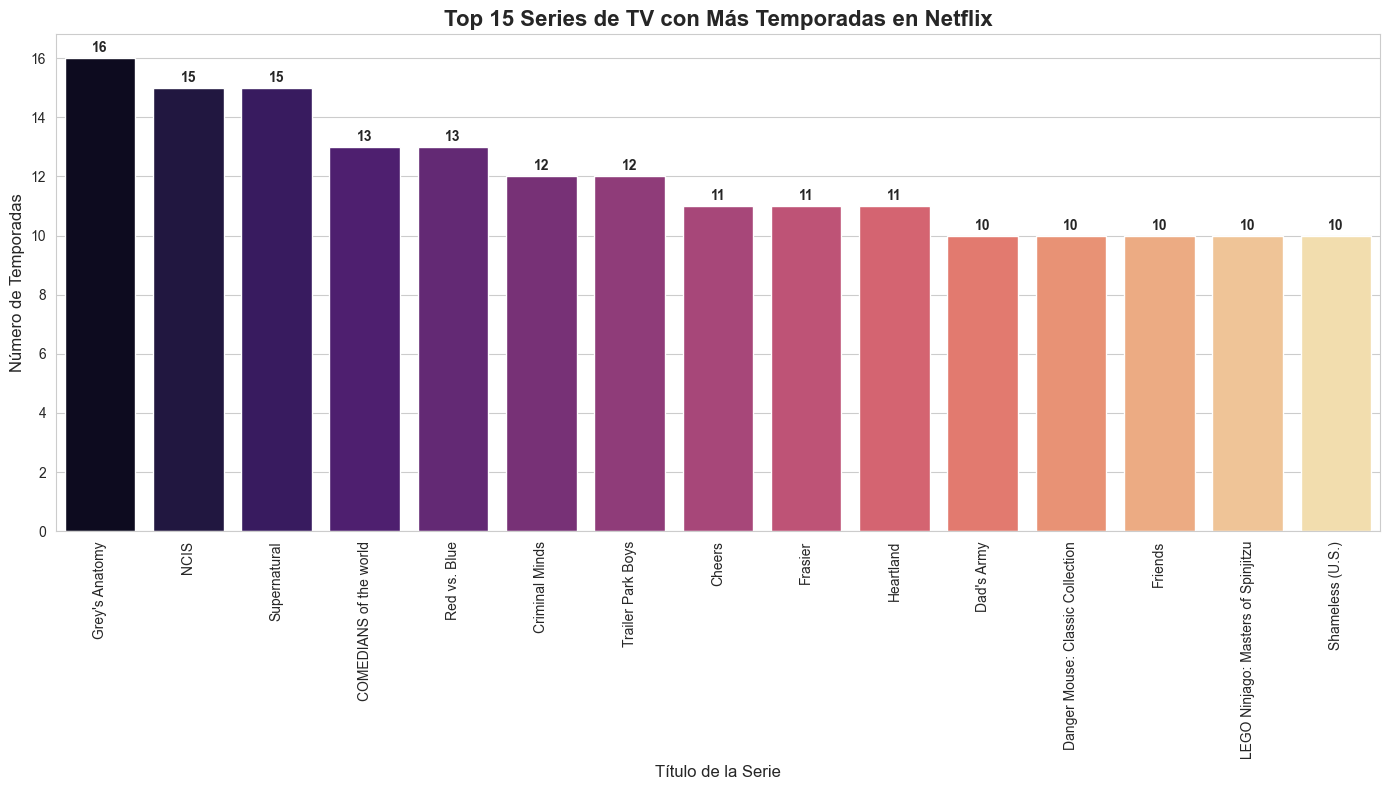

In [17]:
# Filtrar solo Series de TV
netflix_shows = netflix_dataset[netflix_dataset['type'] == 'TV Show'].copy()

# Limpiar la columna 'duration' para extraer el número de temporadas
netflix_shows['duration'] = netflix_shows['duration'].str.replace(' Seasons', '', regex=False)
netflix_shows['duration'] = netflix_shows['duration'].str.replace(' Season', '', regex=False)

# Manejar nulos o texto raro
netflix_shows['duration'] = netflix_shows['duration'].fillna('0')
netflix_shows['duration'] = netflix_shows['duration'].astype(int)

# Obtener las 15 series con más temporadas
top15_seasons = netflix_shows.nlargest(15, 'duration')

# Graficar
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='title',
    y='duration',
    data=top15_seasons,
    palette='magma'
)
plt.xticks(rotation=90)
plt.title('Top 15 Series de TV con Más Temporadas en Netflix', fontsize=16, fontweight='bold')
plt.xlabel('Título de la Serie', fontsize=12)
plt.ylabel('Número de Temporadas', fontsize=12)

# Agregar valores en las barras
for i, v in enumerate(top15_seasons['duration']):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

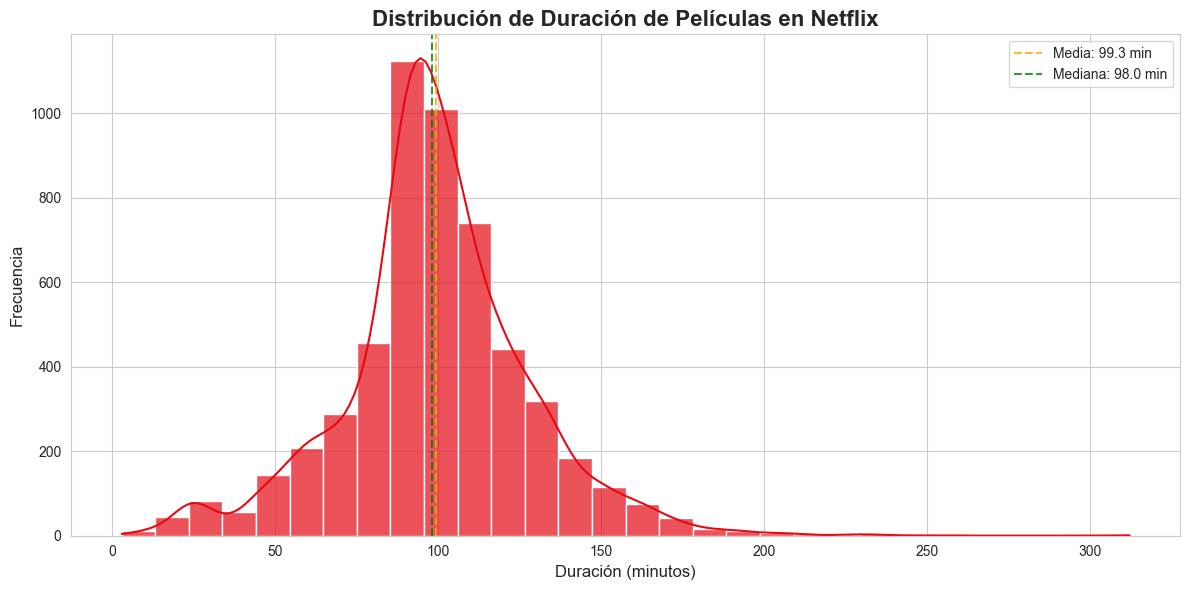

In [18]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.histplot(data=netflix_movies['duration'], bins=30, kde=True, color='#E50914', alpha=0.7)
ax.set_title('Distribución de Duración de Películas en Netflix', fontsize=16, fontweight='bold')
ax.set_xlabel('Duración (minutos)', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)

# Agregar líneas de estadísticas descriptivas
mean_duration = netflix_movies['duration'].mean()
median_duration = netflix_movies['duration'].median()

plt.axvline(mean_duration, color='orange', linestyle='--', alpha=0.8, label=f'Media: {mean_duration:.1f} min')
plt.axvline(median_duration, color='green', linestyle='--', alpha=0.8, label=f'Mediana: {median_duration:.1f} min')

plt.legend()
plt.tight_layout()
plt.show()

## Análisis de la duración de los programas de televisión

/var/folders/8d/cl39xy8929j59619h922mglr0000gq/T/ipykernel_17149/3598440682.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top20, x='title', y='no_of_seasons', palette='coolwarm')


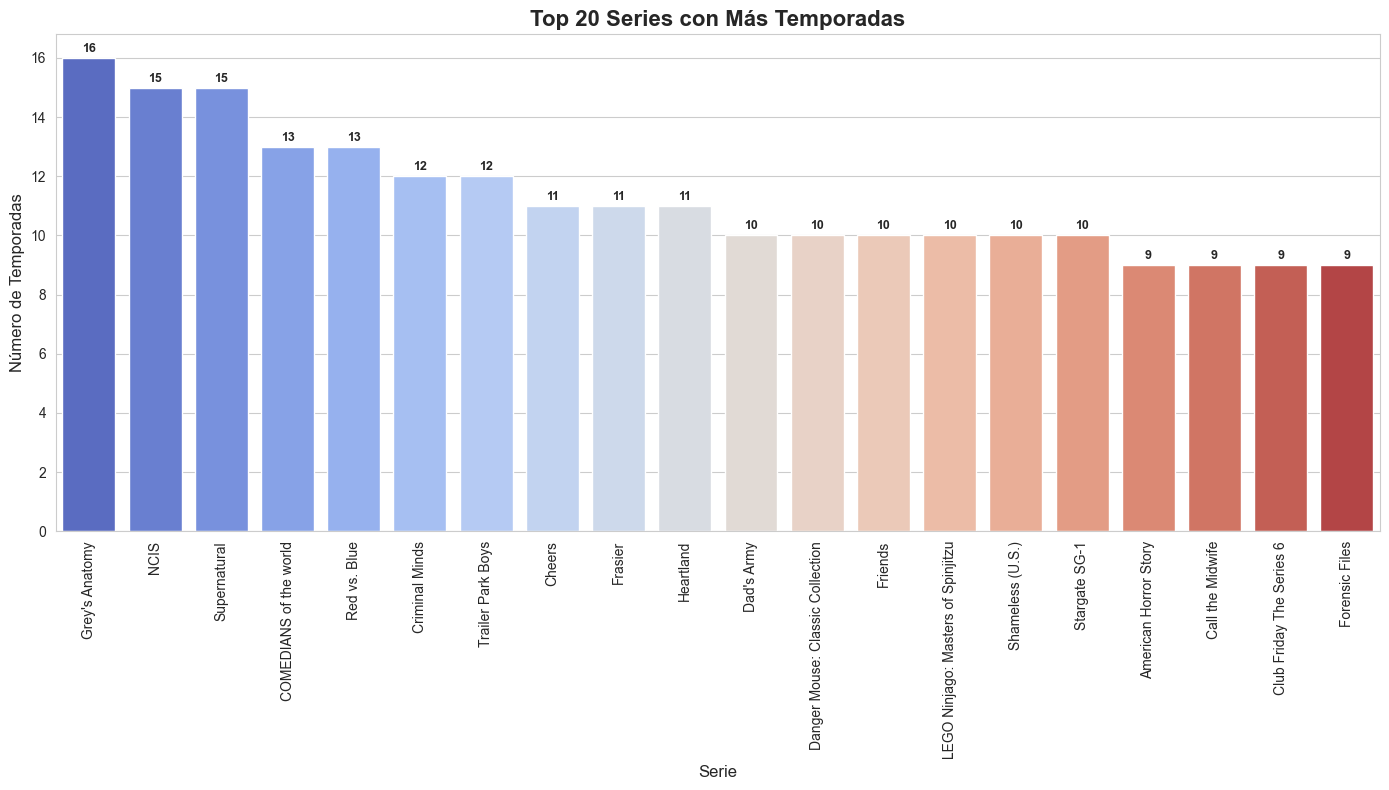

In [19]:
# Análisis simplificado de temporadas
durations = netflix_shows[['title', 'duration']].copy()
durations['no_of_seasons'] = durations['duration'].fillna(0).astype(int)

# Top 20 series con más temporadas
top20 = durations.nlargest(20, 'no_of_seasons')

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=top20, x='title', y='no_of_seasons', palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Top 20 Series con Más Temporadas', fontsize=16, fontweight='bold')
plt.xlabel('Serie', fontsize=12)
plt.ylabel('Número de Temporadas', fontsize=12)

# Agregar valores en las barras
for i, v in enumerate(top20['no_of_seasons']):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## Sistema de recomendación basado en contenido

In [20]:
# Explorar las descripciones del contenido
print("Primeras 5 descripciones:")
print(netflix_dataset['description'].head())
print(f"\nTotal de descripciones no nulas: {netflix_dataset['description'].notna().sum()}")

Primeras 5 descripciones:
0    In a future where the elite inhabit an island ...
1    After a devastating earthquake hits Mexico Cit...
2    When an army recruit is found dead, his fellow...
3    In a postapocalyptic world, rag-doll robots hi...
4    A brilliant group of students become card-coun...
Name: description, dtype: object

Total de descripciones no nulas: 7787


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear la matriz TF-IDF usando la columna 'description'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(netflix_dataset['description'].fillna(''))

In [22]:
# Construir un mapa inverso de índices y títulos
indices = pd.Series(netflix_dataset.index, index=netflix_dataset['title']).drop_duplicates()
print(f"Índices creados para {len(indices)} títulos únicos")

Índices creados para 7787 títulos únicos


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Crear la matriz TF-IDF usando la columna 'description'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(netflix_dataset['description'].fillna(''))

# Calcular la matriz de similitud de coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Construir un mapa inverso de índices y títulos de películas
indices = pd.Series(netflix_dataset.index, index=netflix_dataset['title']).drop_duplicates()

# Función que toma el título de la película como entrada y genera la mayoría de las películas similares
def get_recommendations(title, cosine_sim=cosine_sim):
    # Obtener el índice de la película que coincide con el título
    idx = indices[title]

    # Obtenga las puntuaciones de similitud de pares de todas las películas con esa película
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordena las películas según los puntajes de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtén las puntuaciones de las 10 películas más similares
    sim_scores = sim_scores[1:11]

    # Obtener los índices de la película
    movie_indices = [i[0] for i in sim_scores]

    # Devuelve el top 10 de películas más similares
    return netflix_dataset['title'].iloc[movie_indices]

In [24]:
# Ejemplo de recomendación: The Ring
print("Recomendaciones para 'The Ring':")
try:
    recommendations = get_recommendations('The Ring')
    for i, movie in enumerate(recommendations, 1):
        print(f"{i}. {movie}")
except KeyError:
    print("'The Ring' no está disponible en el dataset de Netflix")
    # Buscar títulos similares
    similar_titles = netflix_dataset[netflix_dataset['title'].str.contains('Ring', case=False, na=False)]['title'].head()
    if not similar_titles.empty:
        print("Títulos similares encontrados:")
        for title in similar_titles:
            print(f"- {title}")

Recomendaciones para 'The Ring':
1. Chappaquiddick
2. The Staircase
3. 13 Reasons Why
4. An American Tail: The Mystery of the Night Monster
5. American Hangman
6. Gigantosaurus
7. Blood Will Tell
8. 7 Days Out
9. 7 Din Mohabbat In
10. Graceful Friends


In [25]:
# Ejemplo de recomendación: Make My Dreams Come True
print("Recomendaciones para 'Make My Dreams Come True':")
try:
    recommendations = get_recommendations('Make My Dreams Come True')
    for i, movie in enumerate(recommendations, 1):
        print(f"{i}. {movie}")
except KeyError:
    print("'Make My Dreams Come True' no está disponible en el dataset de Netflix")
    # Buscar títulos similares
    similar_titles = netflix_dataset[netflix_dataset['title'].str.contains('dream', case=False, na=False)]['title'].head()
    if not similar_titles.empty:
        print("Títulos con 'dream' encontrados:")
        for title in similar_titles:
            print(f"- {title}")

Recomendaciones para 'Make My Dreams Come True':
'Make My Dreams Come True' no está disponible en el dataset de Netflix
Títulos con 'dream' encontrados:
- 2015 Dream Concert
- 2307: Winter's Dream
- Barça Dreams
- Barbie Dreamhouse Adventures
- Barbie Dreamhouse Adventures: Go Team Roberts


In [26]:
# Ejemplo de recomendación: Elite
print("Recomendaciones para 'Elite':")
try:
    recommendations = get_recommendations('Elite')
    for i, movie in enumerate(recommendations, 1):
        print(f"{i}. {movie}")
except KeyError:
    print("'Elite' no está disponible en el dataset de Netflix")
    # Buscar títulos similares
    similar_titles = netflix_dataset[netflix_dataset['title'].str.contains('Elite', case=False, na=False)]['title'].head()
    if not similar_titles.empty:
        print("Títulos similares encontrados:")
        for title in similar_titles:
            print(f"- {title}")

Recomendaciones para 'Elite':
1. Rebelde
2. Silvana Sin Lana
3. Inheritors
4. Moms at War
5. Being Elmo: A Puppeteer's Journey
6. School Life
7. ThirTEEN Terrors
8. Pokémon the Series
9. Revolutionary Love
10. Locust


In [27]:
# Ejemplo de recomendación: The Walking Dead
print("Recomendaciones para 'The Walking Dead':")
try:
    recommendations = get_recommendations('The Walking Dead')
    for i, movie in enumerate(recommendations, 1):
        print(f"{i}. {movie}")
except KeyError:
    print("'The Walking Dead' no está disponible en el dataset de Netflix")
    # Buscar títulos similares
    similar_titles = netflix_dataset[netflix_dataset['title'].str.contains('Walking|Dead', case=False, na=False)]['title'].head()
    if not similar_titles.empty:
        print("Títulos similares encontrados:")
        for title in similar_titles:
            print(f"- {title}")

Recomendaciones para 'The Walking Dead':
1. Into the Forest
2. Black Summer
3. Here Alone
4. Bokeh
5. The Stranded
6. Legion
7. Expelled from Paradise
8. Day of the Dead: Bloodline
9. Bill Burr: I'm Sorry You Feel That Way
10. Beyond Skyline


In [28]:
#Rellenar valores nulos con una cadena vacía.
filledna=netflix_dataset.fillna('')
filledna.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [29]:
# Función para limpiar datos de texto
def clean_data(x):
    return str.lower(x.replace(" ", ""))

In [30]:
# Seleccionar características para el sistema de recomendación mejorado
features = ['title', 'director', 'cast', 'listed_in', 'description']
filledna = netflix_dataset[features].fillna('')

In [31]:
# Aplicar limpieza de datos a todas las características
for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)
    
print("Datos limpiados:")
filledna.head()

Datos limpiados:


,title,director,cast,listed_in,description
0,3%,,"joãomiguel,biancacomparato,michelgomes,rodolfo...","internationaltvshows,tvdramas,tvsci-fi&fantasy",inafuturewheretheeliteinhabitanislandparadisef...
1,07:19,jorgemichelgrau,"demiánbichir,héctorbonilla,oscarserrano,azalia...","dramas,internationalmovies","afteradevastatingearthquakehitsmexicocity,trap..."
2,23:59,gilbertchan,"teddchan,stellachung,henleyhii,lawrencekoh,tom...","horrormovies,internationalmovies","whenanarmyrecruitisfounddead,hisfellowsoldiers..."
3,9,shaneacker,"elijahwood,johnc.reilly,jenniferconnelly,chris...","action&adventure,independentmovies,sci-fi&fantasy","inapostapocalypticworld,rag-dollrobotshideinfe..."
4,21,robertluketic,"jimsturgess,kevinspacey,katebosworth,aaronyoo,...",dramas,abrilliantgroupofstudentsbecomecard-countingex...


## Combinación de características

Combinamos título, director, actores, género y descripción en una sola característica.

In [32]:
def create_soup(x):
    return x['title']+ ' ' + x['director'] + ' ' + x['cast'] + ' ' +x['listed_in']+' '+ x['description']

filledna['soup'] = filledna.apply(create_soup, axis=1)

In [33]:
# Importa CountVectorizer y crea la matriz de conteo
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(filledna['soup'])

In [34]:
# Calcule la matriz de similitud de coseno basándose en count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [35]:
# Restablecer el índice de nuestro DataFrame principal y construir un mapeo inverso como antes
filledna=filledna.reset_index()
indices = pd.Series(filledna.index, index=filledna['title'])

In [36]:
# a) ¿Cuántas series tiene el data set?
num_series = netflix_dataset[netflix_dataset['type'] == 'TV Show'].shape[0]
print(f"Series: {num_series}")  # Esperado: 2410

# b) ¿Cuántas películas tiene el data set?
num_movies = netflix_dataset[netflix_dataset['type'] == 'Movie'].shape[0]
print(f"Películas: {num_movies}")  # Esperado: 5377

# c) ¿Cuántos títulos tiene el data set?
num_titles = netflix_dataset['title'].nunique()
print(f"Títulos únicos: {num_titles}")  # Esperado: 7783

# d) ¿Cuáles son los atributos llave del data set?
columns = list(netflix_dataset.columns)
print(f"Atributos clave: {columns}")  # Esperado: show_id y title

Series: 2410
Películas: 5377
Títulos únicos: 7787
Atributos clave: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


In [37]:
import pandas as pd
import os

# Leer datasets disponibles en la carpeta data/
files = []
if os.path.exists('data/netflix_dataset.csv'):
    files.append(pd.read_csv('data/netflix_dataset.csv'))
    print("✅ Dataset principal cargado desde data/netflix_dataset.csv")

# Verificar si hay datasets adicionales
additional_datasets = ['data/netflix_dataset_2025.csv', 'data/netflix_movies_2025.csv']
for dataset in additional_datasets:
    if os.path.exists(dataset):
        files.append(pd.read_csv(dataset))
        print(f"✅ Dataset adicional cargado: {dataset}")

if not files:
    raise FileNotFoundError("No se encontró ningún archivo de dataset de Netflix en data/.")

# Si hay múltiples archivos, combinarlos
if len(files) > 1:
    netflix_full = pd.concat(files, ignore_index=True)
    if 'show_id' in netflix_full.columns:
        netflix_full = netflix_full.drop_duplicates(subset=['show_id'])
    else:
        netflix_full = netflix_full.drop_duplicates(subset=['title'])
    
    # Guardar el dataset combinado
    netflix_full.to_csv('data/netflix_full_2025.csv', index=False)
    print(f"Archivo combinado guardado como data/netflix_full_2025.csv")
else:
    print("Usando dataset único disponible")

✅ Dataset principal cargado desde data/netflix_dataset.csv
Usando dataset único disponible


In [38]:
import numpy as np

# Usar el dataset combinado si existe, sino usar el principal
if os.path.exists('data/netflix_full_2025.csv'):
    netflix_dataset = pd.read_csv('data/netflix_full_2025.csv')
    print("Usando dataset combinado")
else:
    netflix_dataset = pd.read_csv('data/netflix_dataset.csv')
    print("Usando dataset principal")

netflix_dataset['description'] = netflix_dataset['description'].replace('', np.nan)
netflix_dataset = netflix_dataset.dropna(subset=['description']).reset_index(drop=True)
print("Dimensiones después de limpiar:", netflix_dataset.shape)

Usando dataset principal
Dimensiones después de limpiar: (7787, 12)


In [39]:
# Versión optimizada del sistema de recomendación
print("🚀 Optimizando sistema de recomendación...")

# Usar un subset más pequeño para hacer el proceso más rápido
sample_size = min(2000, len(netflix_dataset))  # Limitar a 2000 títulos para velocidad
netflix_sample = netflix_dataset.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"📊 Procesando {sample_size} títulos para recomendaciones rápidas...")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Configurar TF-IDF con parámetros optimizados
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,  # Limitar características
    max_df=0.85,        # Ignorar términos muy comunes
    min_df=2            # Ignorar términos muy raros
)

tfidf_matrix = tfidf.fit_transform(netflix_sample['description'].fillna(''))
print(f"✅ Matriz TF-IDF creada: {tfidf_matrix.shape}")

# Calcular similitud (esto debería ser mucho más rápido)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(f"✅ Matriz de similitud calculada: {cosine_sim.shape}")

# Crear índices
indices = pd.Series(netflix_sample.index, index=netflix_sample['title']).drop_duplicates()
print(f"✅ Sistema optimizado listo con {len(indices)} títulos")

🚀 Optimizando sistema de recomendación...
📊 Procesando 2000 títulos para recomendaciones rápidas...
✅ Matriz TF-IDF creada: (2000, 3776)
✅ Matriz de similitud calculada: (2000, 2000)
✅ Sistema optimizado listo con 2000 títulos


In [40]:
# 🚀 VERSIÓN ULTRA-RÁPIDA - Solo para pruebas
print("⚡ Creando sistema de recomendación ultra-rápido...")

# Usar solo 500 títulos para máxima velocidad
quick_sample = netflix_dataset.sample(n=500, random_state=42).reset_index(drop=True)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF con configuración mínima
quick_tfidf = TfidfVectorizer(
    stop_words='english', 
    max_features=1000,  # Solo 1000 características
    ngram_range=(1, 1)  # Solo palabras individuales
)

quick_matrix = quick_tfidf.fit_transform(quick_sample['description'].fillna(''))
quick_sim = cosine_similarity(quick_matrix)
quick_indices = pd.Series(quick_sample.index, index=quick_sample['title']).drop_duplicates()

print(f"✅ Sistema rápido listo: {len(quick_sample)} títulos en {quick_sim.shape}")

def quick_recommendations(title, n=5):
    """Recomendaciones ultra-rápidas"""
    if title not in quick_indices:
        print(f"'{title}' no encontrado en muestra rápida")
        return []
    
    idx = quick_indices[title]
    scores = list(enumerate(quick_sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:n+1]
    
    return [quick_sample.iloc[i]['title'] for i, _ in scores]

print("⚡ Función rápida lista - debería ejecutarse en segundos")

⚡ Creando sistema de recomendación ultra-rápido...
✅ Sistema rápido listo: 500 títulos en (500, 500)
⚡ Función rápida lista - debería ejecutarse en segundos


In [41]:
# 🧪 Probar el sistema rápido
print("🎬 Probando recomendaciones rápidas...")

# Mostrar algunos títulos disponibles
print("\n📋 Algunos títulos disponibles en la muestra:")
sample_titles = quick_sample['title'].head(10).tolist()
for i, title in enumerate(sample_titles, 1):
    print(f"{i}. {title}")

# Probar con el primer título
test_title = sample_titles[0]
print(f"\n🔍 Recomendaciones para '{test_title}':")

recommendations = quick_recommendations(test_title, n=5)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print(f"\n⏱️ ¡Sistema ejecutado en segundos en lugar de minutos!")

🎬 Probando recomendaciones rápidas...

📋 Algunos títulos disponibles en la muestra:
1. Unchained: The Untold Story of Freestyle Motocross
2. Our Idiot Brother
3. Chhota Bheem Kungfu Dhamaka
4. Ravenous
5. 3 Seconds Divorce
6. Listen
7. Lady, la vendedora de rosas
8. An American Tail: The Mystery of the Night Monster
9. Tere Naal Love Ho Gaya
10. Kaal

🔍 Recomendaciones para 'Unchained: The Untold Story of Freestyle Motocross':
1. NOVA: Extreme Animal Weapons
2. 20 Feet From Stardom
3. Cracked Up: The Darrell Hammond Story
4. Big Time
5. Revenge of the Green Dragons

⏱️ ¡Sistema ejecutado en segundos en lugar de minutos!


In [42]:
# Función de recomendación optimizada
def get_recommendations_fast(title, cosine_sim=cosine_sim, df=netflix_sample):
    """
    Función optimizada para generar recomendaciones rápidas
    """
    if title not in indices:
        # Buscar títulos similares
        similar_titles = df[df['title'].str.contains(title.split()[0], case=False, na=False)]['title'].head(3)
        if not similar_titles.empty:
            print(f"'{title}' no encontrado. Títulos similares:")
            for similar in similar_titles:
                print(f"  - {similar}")
            return []
        else:
            print(f"'{title}' no está en el dataset.")
            return []
    
    # Obtener el índice del título
    idx = indices[title]
    
    # Calcular scores de similitud
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    
    # Obtener índices de películas recomendadas
    movie_indices = [i for i, _ in sim_scores]
    
    # Retornar recomendaciones con scores
    recommendations = []
    for i in movie_indices:
        recommendations.append({
            'title': df.iloc[i]['title'],
            'type': df.iloc[i]['type'],
            'year': df.iloc[i]['release_year'],
            'rating': df.iloc[i]['rating']
        })
    
    return recommendations

print("✅ Función de recomendación optimizada lista")

✅ Función de recomendación optimizada lista


In [43]:
def get_recommendations(title, cosine_sim=cosine_sim):
    if title not in indices:
        print(f"'{title}' no está en el dataset.")
        return []
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    movie_indices = [i for i, _ in sim_scores]
    return list(netflix_dataset['title'].iloc[movie_indices])

In [44]:
test_titles = ['The Ring', 'Elite', 'Make My Dreams Come True']

for title in test_titles:
    print(f"\n=== Recomendaciones para '{title}' ===")
    try:
        recommendations = get_recommendations(title)
        if recommendations:
            for i, movie in enumerate(recommendations[:5], 1):
                print(f"{i}. {movie}")
        else:
            print("No se encontraron recomendaciones")
    except:
        print(f"'{title}' no está disponible en el dataset")
        # Buscar títulos similares
        similar = netflix_dataset[netflix_dataset['title'].str.contains(title.split()[0], case=False, na=False)]['title'].head(3)
        if not similar.empty:
            print("Títulos similares:")
            for s_title in similar:
                print(f"- {s_title}")


=== Recomendaciones para 'The Ring' ===
1. 187
2. Elf Pets: A Fox Cub’s Christmas Tale
3. 72 Cutest Animals
4. DreamWorks Happy Holidays from Madagascar
5. Dragons: Rescue Riders: Secrets of the Songwing

=== Recomendaciones para 'Elite' ===
1. Dragonkala Ka Rahasya
2. Club Friday The Series 6
3. Class of '83
4. Bridget Christie: Stand Up for Her
5. Bbuddah Hoga Terra Baap

=== Recomendaciones para 'Make My Dreams Come True' ===
'Make My Dreams Come True' no está en el dataset.
No se encontraron recomendaciones


## Resumen del Análisis

Este notebook ha demostrado:

1. **Análisis Exploratorio**: Distribución de contenido, patrones temporales y características del catálogo
2. **Visualizaciones Mejoradas**: Gráficas con paletas de colores optimizadas y información clara
3. **Sistema de Recomendación**: Implementación de dos enfoques:
   - Basado solo en descripción (TF-IDF)
   - Basado en múltiples características (director, cast, género, descripción)

El sistema puede recomendar contenido similar basándose en la similitud semántica del contenido existente en Netflix.